In [29]:
import scanpy
import magic
from sklearn import decomposition
import numpy as np
import scprep
import matplotlib.pyplot as plt
import phate
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns

In [30]:
adata_endocrine = scanpy.read_h5ad('data/all_endocrine_processed.h5ad')

In [31]:
usamples = ["WT", "OB/OB", "WT", "HFD"]
lut = {usamples[i]: plt.get_cmap("tab10")(i) for i in range(4)}

In [32]:
gene_subset_only = ["Ins1", 'Ins2', 'Sst', 'Ppy', 'Gcg']

In [33]:
adata_endocrine_without_high_genes = adata_endocrine[:, ~adata_endocrine.var['names'].isin(gene_subset_only)]

#### combined_magic_pc_norm with bad beta cells

In [14]:
magic_op = magic.MAGIC(random_state=42)
data_magic = magic_op.fit_transform(adata_endocrine_without_high_genes)

Calculating MAGIC...
  Running MAGIC on 20294 cells and 16478 genes.
  Calculating graph and diffusion operator...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 7.66 seconds.
    Calculating KNN search...
    Calculated KNN search in 70.72 seconds.
    Calculating affinities...
    Calculated affinities in 69.70 seconds.
  Calculated graph and diffusion operator in 149.24 seconds.
  Running MAGIC with `solver='exact'` on 16478-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 25.47 seconds.


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


Calculated MAGIC in 176.42 seconds.


In [15]:
pc_op = decomposition.PCA(n_components=10, random_state=42)
data_magic_pc = pc_op.fit_transform(data_magic.to_df())
data_magic_pc_norm = data_magic_pc / np.std(data_magic_pc[:, 0])

In [16]:
adata_endocrine.obsm['data_magic_pc_norm'] = data_magic_pc_norm

<Axes: >

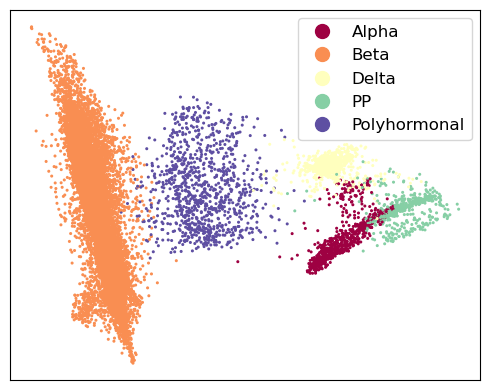

In [54]:
scprep.plot.scatter2d(data_magic_pc_norm, c=adata_endocrine.obs['cell_types'],
                      ticks=None, cmap='Spectral', figsize=(5,4),
                      filename='figures/endocrine_cells_magic_pc.png', dpi=300)

<Axes: >

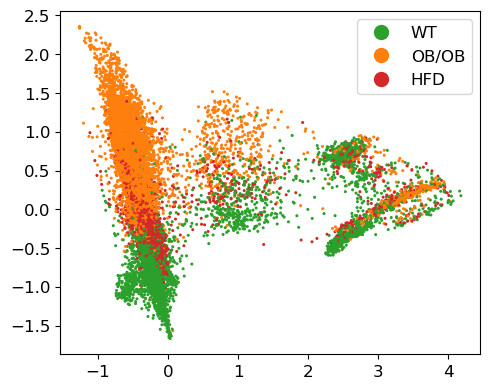

In [35]:
scprep.plot.scatter2d(data_magic_pc_norm, c=adata_endocrine.obs['samples'], cmap=lut, figsize=(5,4),
                      filename='figures/endocrine_cells_magic_pc_samples.png', dpi=300)

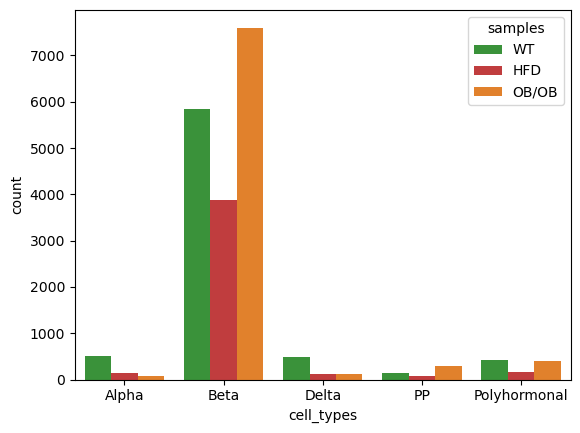

In [39]:
df = pd.DataFrame(adata_endocrine.obs[['samples', 'cell_types']].value_counts()).reset_index()
fig = plt.figure()
ax = sns.barplot(df, x='cell_types', y='count', hue='samples', palette=lut, hue_order=['WT', 'HFD', 'OB/OB'])
fig.savefig('figures/clusters_counts.png')

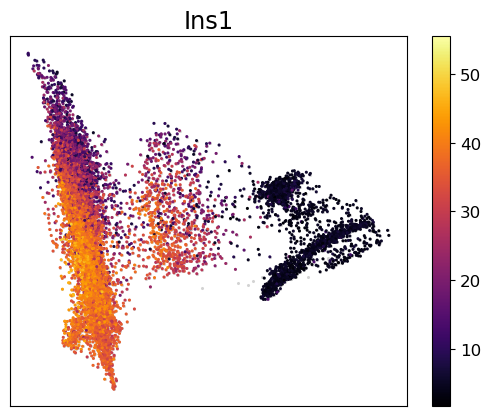

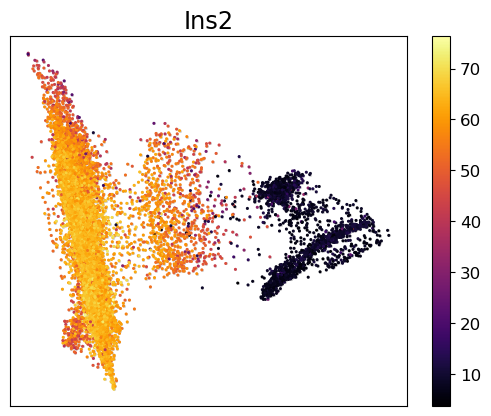

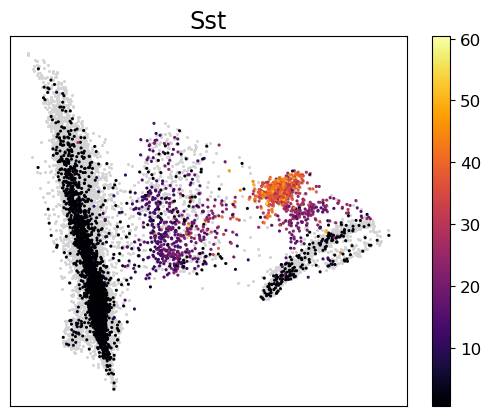

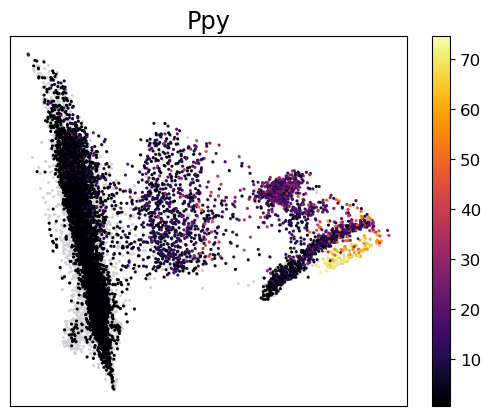

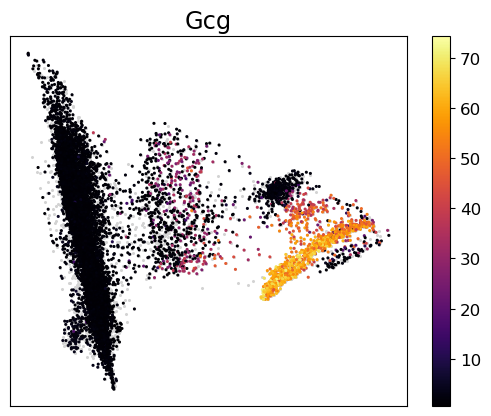

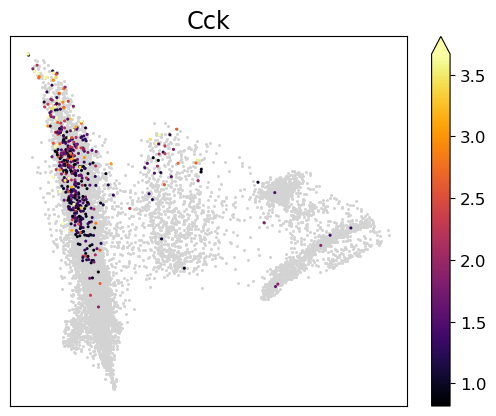

In [37]:
for gene in ['Ins1', 'Ins2', 'Sst', 'Ppy', 'Gcg', 'Cck']:
    fig, ax = plt.subplots()
    scprep.plot.scatter2d(data_magic_pc_norm, c='lightgray', ax=ax)
    if gene == 'Cck':
        vmax = np.percentile(adata_endocrine[:, adata_endocrine.var['names'].values == gene].to_df().values, 99.9)
    else:
        vmax=None
    scprep.plot.scatter2d(data_magic_pc_norm, c=adata_endocrine[:, adata_endocrine.var['names'].values == gene].to_df().values, title=gene, 
                          mask=adata_endocrine[:, adata_endocrine.var['names'].values == gene].to_df().values !=0, ax=ax, vmax=vmax, ticks=None)
    fig.savefig(f'figures/endocrine_{gene}.png', dpi=300)

In [48]:
np.savez('data/endocrine_cells_for_trajectorynet.npz',
         pca=adata_endocrine.obsm['data_magic_pc_norm'],
         sample_labels=adata_endocrine.obs['TrajectoryNet_timepoints'])